## LD block definition for the nanopore haplotype inference project
### Yosuke Tanigawa (2017/7/24)

## Summary:
This note describes
1. PLINK --blocks command to generate .block.det file
1. method to generate bed file (region, not the genotype file) for our definition of LD blocks

We imposed extra filter on the SNPs in the input data:
- hwe 1e-10
- genotype rate >= 10%

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import bisect

In [3]:
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

## 1) PLINK --blocks command
- We used plink 1.9 --blocks option to compute the LD blocks
- https://www.cog-genomics.org/plink2/ld

In [4]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'

In [5]:
!cat $data_dir$geno_bed_log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/private_data/ukbb/pgen/chr20impv1
  --biallelic-only strict
  --geno
  --hwe 1e-10 midp
  --keep /share/PI/mrivas/data/ukbb/phefiles/initialdata/1389.phe
  --maf 0.005
  --make-bed
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --snps-only just-acgt

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:24:21 2017

Random number seed: 1498260261
257674 MB RAM detected; reserving 30000 MB for main workspace.
1540220 out of 1619597 variants loaded from .bim file.
152249 people (0 males, 0 females, 152249 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.nosex
.
--keep: 112338 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Befo

In [6]:
!cat $data_dir$block_log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --blocks no-pheno-req no-small-max-span
  --blocks-inform-frac 0.10
  --blocks-max-kb 1000
  --blocks-recomb-highci 0.830001
  --blocks-strong-highci 0.830001
  --blocks-strong-lowci 0.50001
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:32:58 2017

Random number seed: 1498260778
257674 MB RAM detected; reserving 30000 MB for main workspace.
198418 variants loaded from .bim file.
112338 people (0 males, 0 females, 112338 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-bl

### blocks.det file
- the results of the PLINK 1.9 --blocks command is shown below:

In [7]:
block_det_f = '{}{}.blocks.det'.format(
    data_dir,
    block_log[:-4]
)

In [8]:
block_det = pd.read_csv(block_det_f, sep='\s+')
print(block_det.shape)
block_det.head()

(642, 6)


,CHR,BP1,BP2,KB,NSNPS,SNPS
0,20,62731,93931,31.201,30,rs34147676|rs6139074|rs1418258|rs13043000|rs60...
1,20,94952,266511,171.560,545,rs1857092|rs80192833|rs6052070|rs6515824|rs605...
2,20,266792,287529,20.738,56,rs6137140|rs6082182|rs6082191|rs6082211|rs6075...
3,20,288776,344195,55.420,86,rs4815163|rs62191394|rs6075996|rs6082956|rs723...
4,20,344631,345864,1.234,4,rs6084202|rs2017171|rs1555318|rs6051490


### The mean and median of size and # SNPs
- Here, SNPs with 5% + is used to define our blocks

In [9]:
np.mean(block_det.KB), np.median(block_det.KB)

(91.540046728972, 25.412500000000001)

In [10]:
np.mean(block_det.NSNPS), np.median(block_det.NSNPS)

(194.96728971962617, 50.0)

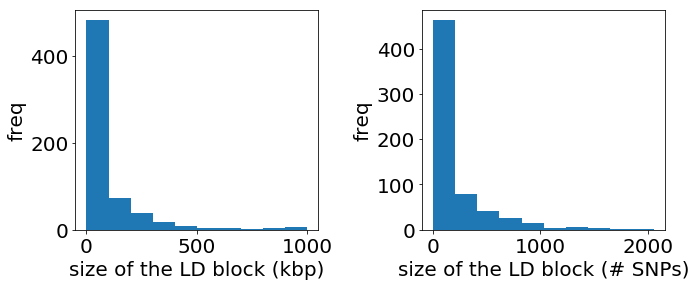

In [11]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)
axs = [fig.add_subplot(ss) for ss in gs]
axs[0].hist(block_det.KB)
axs[1].hist(block_det.NSNPS)
axs[0].set_xlabel('size of the LD block (kbp)')
axs[1].set_xlabel('size of the LD block (# SNPs)')
axs[0].set_ylabel('freq')
axs[1].set_ylabel('freq')
# axs[0].set_title('')
# axs[1].set_title('')
# fig_conf_curves.suptitle('')
gs.tight_layout(fig, rect=[0, 0, 1, 0.88])

## 2) conver to bed file
### motivation
- The blocks we found in the previous step does not fully cover the chromosome

### method
- Given the block.det file and bim file (that has all the SNPs we consider), we *define* LD-based blocks
- block.det is essentially a list of intervals [[BP1_1, BP2_1), [BP1_2, BP2_2), ... , [BP1_n, BP2_n)]
  - [x, y) denotes semi-open intervals where x is included in the interval while y isn't
- Our definition of the blocks are: [[0, BP1_2), [BP1_2, BP1_3), [BP1_3, BP1_4), ... , [BP1_{n-1}, BP1_n), [BP1_{n-1}, end_of_chromosome]]

In [12]:
bim_f = '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic.bim'

In [13]:
bim = pd.read_csv(bim_f, sep='\t', names=['chr', 'rsid', 'genetic_dist', 'pos', 'a1', 'a2'])
print(bim.shape)
bim.tail()

(205378, 6)


,chr,rsid,genetic_dist,pos,a1,a2
205373,20,rs578065922,0,62957957,A,G
205374,20,rs146252638,0,62958306,T,C
205375,20,rs11698187,0,62960292,G,A
205376,20,rs140775622,0,62962869,T,C
205377,20,rs542224338,0,62963102,C,T


- bim file is 1-indexed

- check several statistics

In [14]:
block_det.BP1[0], block_det.BP2[len(block_det) - 1], bim.pos[0], bim.pos[len(bim) -1], len(block_det), len(bim)

(62731, 62918861, 61098, 62963102, 642, 205378)

- convert to intervals that cover the entire chromosome

In [15]:
interval_points = np.zeros(len(block_det) + 1, dtype=np.int)
interval_points[1:-1] = block_det.BP1.as_matrix()[1:]
interval_points[0] = bim.pos[0] - 1
interval_points[-1] = bim.pos[len(bim) -1] - 1

- we also want to store the intervals on bim-id space

In [16]:
bim_pos_0index = bim.pos.map(lambda x: x - 1).as_matrix()
bim_pos_0index

array([   61097,    61269,    61794, ..., 62960291, 62962868, 62963101])

In [17]:
interval_points_bimid = np.array([bisect.bisect_left(bim_pos_0index, x) for x in interval_points])
interval_points_bimid[:10]

array([   0,   86,  938, 1027, 1270, 1277, 1446, 1505, 1974, 2030])

### the results are represented as a data frame and stored in a bed file

In [18]:
bed_df = pd.DataFrame({
    'chrom': ['chr20'] * len(block_det),
    'chromStart': interval_points[:-1],
    'chromEnd':   interval_points[1:],
    'bimIdStart': interval_points_bimid[:-1],
    'bimIdEnd':   interval_points_bimid[1:]
})

In [19]:
bed_df['name'] = ['{}:{}'.format(bed_df.bimIdStart[x], bed_df.bimIdEnd[x]) for x in range(len(bed_df))]

In [20]:
print(bed_df.shape)
print(bed_df.head())
print(bed_df.tail())

(642, 6)
   bimIdEnd  bimIdStart  chrom  chromEnd  chromStart       name
0        86           0  chr20     94952       61097       0:86
1       938          86  chr20    266792       94952     86:938
2      1027         938  chr20    288776      266792   938:1027
3      1270        1027  chr20    344631      288776  1027:1270
4      1277        1270  chr20    346676      344631  1270:1277
     bimIdEnd  bimIdStart  chrom  chromEnd  chromStart           name
637    202502      202485  chr20  62196807    62193587  202485:202502
638    203807      202502  chr20  62475881    62196807  202502:203807
639    203835      203807  chr20  62481351    62475881  203807:203835
640    205197      203835  chr20  62871952    62481351  203835:205197
641    205377      205197  chr20  62963101    62871952  205197:205377


In [21]:
bed_f = '{}.bed'.format(block_det_f[:-11])
print(bed_f)

/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.bed


In [22]:
bed_df[['chrom', 'chromStart', 'chromEnd', 'name']].to_csv(bed_f, header=False, index=False, sep='\t')

In [23]:
!head $bed_f

chr20	61097	94952	0:86
chr20	94952	266792	86:938
chr20	266792	288776	938:1027
chr20	288776	344631	1027:1270
chr20	344631	346676	1270:1277
chr20	346676	368905	1277:1446
chr20	368905	381670	1446:1505
chr20	381670	536536	1505:1974
chr20	536536	546546	1974:2030
chr20	546546	549907	2030:2046


### the size of the blocks

In [24]:
bed_df['len'] = bed_df.chromEnd - bed_df.chromStart
bed_df['nSNPs'] = bed_df.bimIdEnd - bed_df.bimIdStart

In [25]:
print(np.mean(block_det.KB), np.median(block_det.KB))
print(np.mean(bed_df.len/1000), np.median(bed_df.len/1000))

91.540046728972 25.4125
97.97819937694705 27.0065


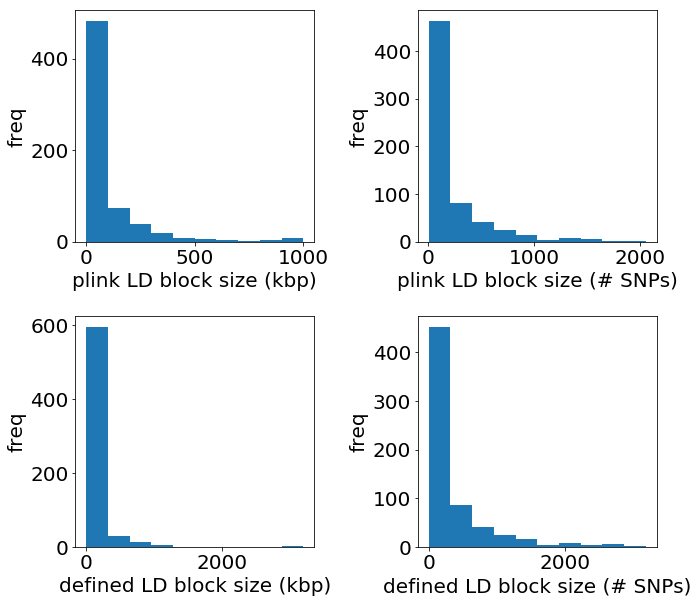

In [26]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
axs = [fig.add_subplot(ss) for ss in gs]
axs[0].hist(block_det.KB)
axs[1].hist(block_det.NSNPS)
axs[2].hist(bed_df.len/1000)
axs[3].hist(bed_df.nSNPs)
axs[0].set_xlabel('plink LD block size (kbp)')
axs[1].set_xlabel('plink LD block size (# SNPs)')
axs[2].set_xlabel('defined LD block size (kbp)')
axs[3].set_xlabel('defined LD block size (# SNPs)')
for ax in axs:
    ax.set_ylabel('freq')
gs.tight_layout(fig, rect=[0, 0, 1, 0.88])

### The smallest blocks ( top 5 )

In [27]:
bed_df.sort_values(by='len').head()

,bimIdEnd,bimIdStart,chrom,chromEnd,chromStart,name,len,nSNPs
56,10931,10928,chr20,2751855,2751794,10928:10931,61,3
500,171528,171523,chr20,54542872,54542622,171523:171528,250,5
457,160493,160489,chr20,51691989,51691671,160489:160493,318,4
589,190319,190314,chr20,59562420,59562077,190314:190319,343,5
483,164907,164904,chr20,52822642,52822249,164904:164907,393,3


### The largest blocks (top 5)

In [28]:
bed_df.sort_values(by='len', ascending=False).head()

,bimIdEnd,bimIdStart,chrom,chromEnd,chromStart,name,len,nSNPs
294,95444,95166,chr20,29479934,26285874,95166:95444,3194060,278
310,108016,106563,chr20,35449880,34445164,106563:108016,1004716,1453
293,95166,92829,chr20,26285874,25285220,92829:95166,1000654,2337
296,98031,95629,chr20,30526403,29526085,95629:98031,1000318,2402
306,104213,102545,chr20,33538521,32538391,102545:104213,1000130,1668
